In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.decomposition import PCA
import pymc as pm
from scipy.spatial import distance_matrix
from scipy.linalg import block_diag
from scipy.stats import multivariate_normal, norm
from sklearn.linear_model import LinearRegression
import theano.tensor as tt
plt.style.use('ggplot')
plt.rcParams.update({'axes.labelsize':16})
plt.rcParams.update({'axes.titlesize':16})
plt.rcParams.update({'legend.fontsize':16})
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['lines.linewidth'] = 4
os.chdir('../')
from python_code import basic_gibbs
os.chdir('notebooks')

In [18]:
df = pd.read_csv('../formatted_data/transformed_data.csv')
df = df[df['department_name'].isin(np.unique(df['department_name'])[0:2])]
grouped_df = df.groupby('department_name')
groups = list(grouped_df.groups.keys())
X_depts = list(grouped_df.apply(lambda x: np.array(x[['intercept', 'component_1', 'component_2']])))
y_depts = list(grouped_df.apply(lambda x: np.array(x[['avg_change_baseline_incidents']]).flatten()))
df = df.sort_values(['department_name', 'day_of_the_year'])

In [19]:
#distance_mats = [distance_matrix(X.reshape(-1,1), X.reshape(-1,1)) for X in df['day_of_the_year']]
dist = distance_matrix(df['day_of_the_year'].to_numpy().reshape(-1,1), df['day_of_the_year'].to_numpy().reshape(-1,1))

$$
  y_i = N(X_i \beta_i ,  C_i)
$$



$$
  \beta_{ij} \sim N(\mu_j, \tau_j^2)
$$

In [20]:
dept_idxs, dept_names = pd.factorize(df.department_name)
n_depts = len(df.groupby('department_name').groups)

In [21]:
group_sizes = df.groupby('department_name').size().to_numpy()
mats = [np.ones([group_sizes[i], group_sizes[i]]) for i in range(len(group_sizes))]
boolean_block_mat =  block_diag(*mats)

In [22]:
with pm.Model() as model:
    # priors
    mus_betas = pm.Normal('mus_beta', mu=0.0, sigma=10, shape=3)
    sigmas_sq_betas = pm.InverseGamma('sigmas_squared_betas',alpha=0.5, beta=0.5, shape=3)
    betas_offset =  pm.Normal('betas_offset', mu=0, sigma=1, shape=(len(dept_names), 3))
    betas = pm.Deterministic('betas', mus_betas + betas_offset*np.sqrt(sigmas_sq_betas))
    means =  (df[['intercept','component_1','component_2']].to_numpy() * betas[dept_idxs, :]).sum(axis=1)
    
    tau_s1 = pm.InverseGamma("tau_s1", alpha=0.5, beta=0.5, shape=len(dept_names))
    b_mean = pm.TruncatedNormal('b_mean', mu=20, sigma=50, lower=0)
    b_var = pm.InverseGamma('b_var',alpha=0.5, beta=0.5)
    bandwidth = pm.TruncatedNormal('b', mu=b_mean, sigma=np.sqrt(b_var), lower=0, shape=n_depts)
    full_mat = tau_s1[dept_idxs] * np.exp(-dist**2 /bandwidth[dept_idxs]**2)  + np.eye(len(dept_idxs)) * 1e-6
    cov = full_mat * boolean_block_mat
    y_ = pm.MvNormal('y', mu=means, cov=cov, shape=dist.shape[0], observed=df['avg_change_baseline_incidents'])                             
    

In [23]:
with model:
    trace = pm.sample(100, tune=100, init='advi+adapt_diag', target_accept=.99, chains=1, return_inferencedata=False)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 24500
Interrupted at 24,499 [12%]: Average Loss = 1.4706e+05
Sequential sampling (1 chains in 1 job)
NUTS: [mus_beta, sigmas_squared_betas, betas_offset, tau_s1, b_mean, b_var, b]


Sampling 1 chain for 100 tune and 100 draw iterations (100 + 100 draws total) took 38 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


In [16]:
var_list = ['mus_beta', 'sigmas_squared_betas', 'betas', 'tau_s1', 'b_mean', 'b_var', 'b']
traces_dict = [{var: trace.get_values(var)} for var in var_list]
traces_dict

[{'mus_beta': array([[-2.90232965e+00,  1.11429689e-01, -3.57816758e-01],
         [ 2.12560828e+00,  2.57787534e-02, -6.70401992e-02],
         [ 7.24757063e-01,  9.27108229e-02, -7.86404476e-02],
         [-1.73371539e+00,  3.76795673e-02, -3.70171579e-01],
         [-3.93520145e+00, -5.61826472e-01, -4.52532704e-01],
         [-4.88635680e+00, -5.48523523e-01, -5.02124095e-01],
         [ 3.02683523e+00, -6.74550456e-01, -3.34695870e-01],
         [-5.25175321e+00, -3.35361221e-02, -4.39105289e-01],
         [-9.90023314e+00, -7.29917979e-02, -3.05170900e-01],
         [ 6.35277658e-01,  2.84937789e-01, -9.63469714e-01],
         [ 4.46036831e+00,  4.32259753e-01, -6.99547857e-01],
         [ 6.43060240e-01,  4.28464818e-01, -7.51750482e-01],
         [ 5.60738470e-01,  3.86617874e-01, -7.51321189e-01],
         [ 2.24717821e+00,  5.25593979e-01, -8.28501135e-01],
         [-5.61861955e+00,  7.11618652e-01, -8.74378993e-01],
         [ 3.49830918e+00,  5.69876206e-01, -4.58371147e-0

In [12]:
gb = basic_gibbs.GibbsSampler(X_depts, y_depts, n_iter=5000, burn=1000)
gb.fit()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:17<00:00, 284.56it/s]


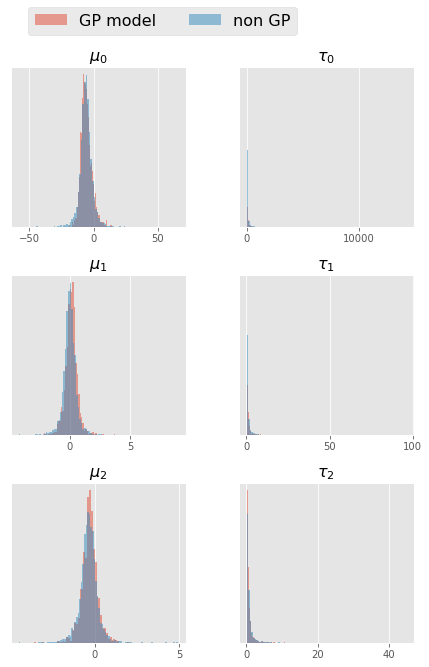

In [13]:
plt.figure(figsize=(7,10), facecolor='white')
for i in range(3):
    plt.subplot(3,2,2*i+1)
    plt.hist(trace.get_values(f'mus_beta')[:, i], density=True,  bins=50, alpha=.5)
    plt.hist(gb.traces['mu'][:,i], density=True,  bins=100, alpha=.5)
    plt.xticks(fontsize=10)
    plt.yticks([])
    string = str(i) 
    plt.title(fr'$\mu_{i}$')
    plt.subplot(3,2,2*i+2)
    plt.hist(trace.get_values(f'sigmas_squared_betas')[:, i], density=True,  bins=50, alpha=.5, label='GP model')
    plt.hist(gb.traces['sigmas_diag'][:,i], density=True,  bins=100, alpha=.5, label='non GP')
    if i ==0:
        plt.legend(loc=(-1.2,1.2), ncol=2)
    plt.xticks(fontsize=10)
    plt.yticks([])
    tot_string = (r'$\tau_' + '{' + string + '}$')
    plt.title(tot_string)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)
plt.savefig('../writeup/pymc_gp_model_means.png', dpi=300, bbox_inches='tight')

In [25]:
import pickle
with open('../python_code/traces.pickle', 'rb') as handle:
    b = pickle.load(handle)

[None, None, None]

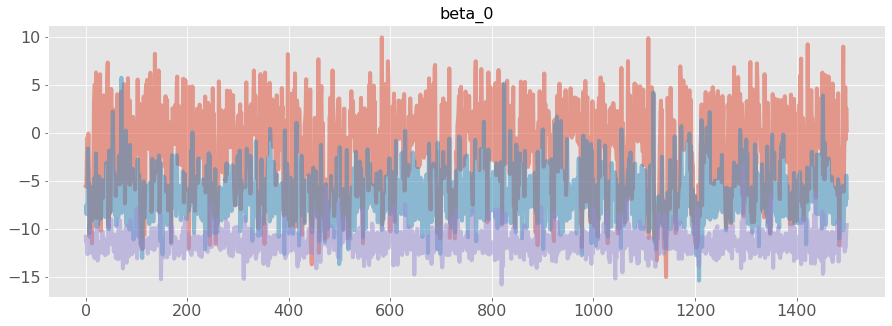

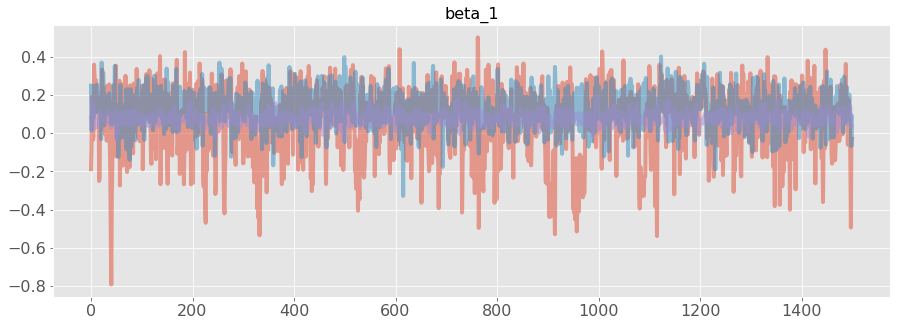

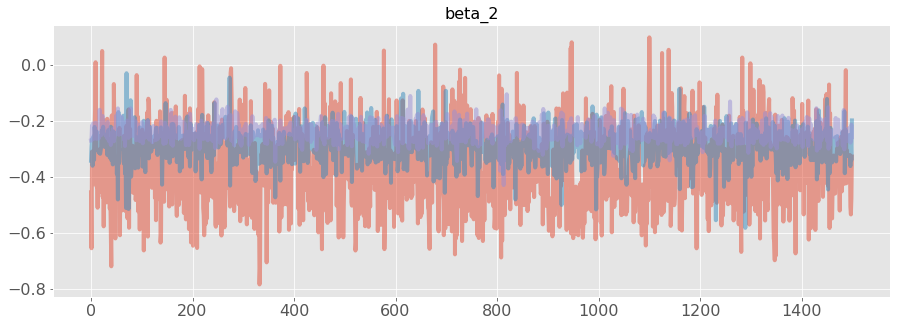

In [14]:
def plot_beta_traces(beta_num):
    plt.figure(figsize=(15,5), facecolor='white')
    plt.plot(trace.get_values(f'betas')[:, :, beta_num], alpha=.5)
    plt.title(f'beta_{beta_num}')
[plot_beta_traces(num) for num in range(3)]

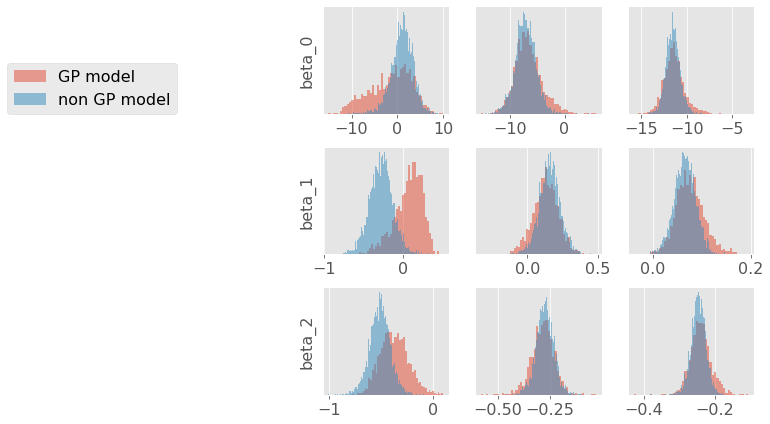

In [16]:
fig, ax = plt.subplots(figsize=(len(groups) * 5, 6), facecolor='white', ncols=len(groups), nrows=3)
for beta_num in range(3):
    for i in range(len(df.groupby('department_name').groups)):
        ax[beta_num, i].hist(trace.get_values(f'betas')[:, :, beta_num][:,i], density=True,  bins=50, alpha=.5, label='GP model')
        ax[beta_num, i].hist(gb.traces['betas'][:,beta_num,i], density=True,  bins=100, alpha=.5, label='non GP model')
        ax[beta_num, i].set_yticks([])
        if i == 0 and beta_num == 0:
            ax[beta_num, i].legend(loc=(-2.5, 0))
        if i % len(groups) == 0:
            ax[beta_num, i].set_ylabel(f'beta_{beta_num}')
        
plt.tight_layout()
plt.savefig('../figures/betas_pymc_gp.png', dpi=300, bbox_inches='tight')

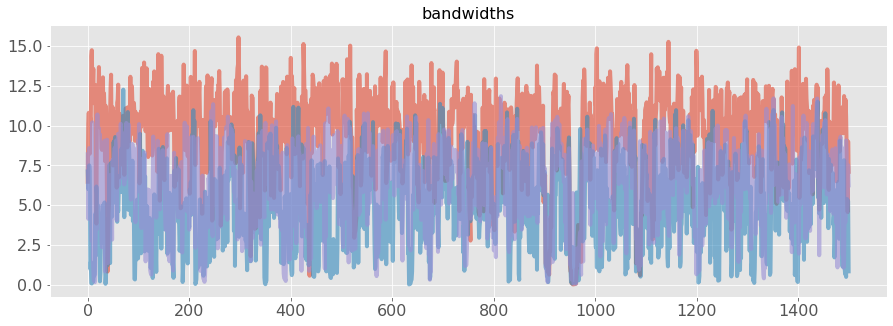

<Figure size 432x288 with 0 Axes>

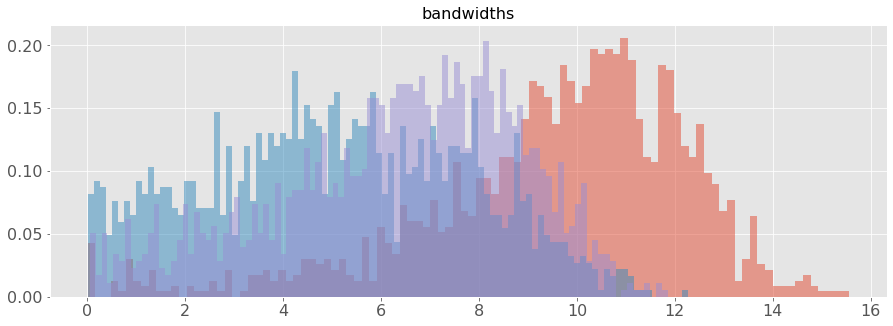

In [19]:
plt.figure(figsize=(15,5), facecolor='white')
plt.plot(trace.get_values('b'), alpha=.6)
plt.title('bandwidths');
plt.figure()
plt.figure(figsize=(15,5), facecolor='white')
for i in range(trace.get_values('b').shape[1]):
    plt.hist(trace.get_values('b')[:, i], bins=100, density=True, alpha=.5)
plt.title('bandwidths');

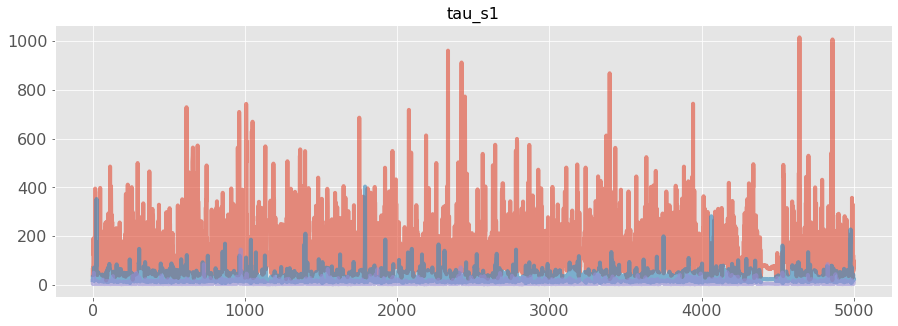

<Figure size 432x288 with 0 Axes>

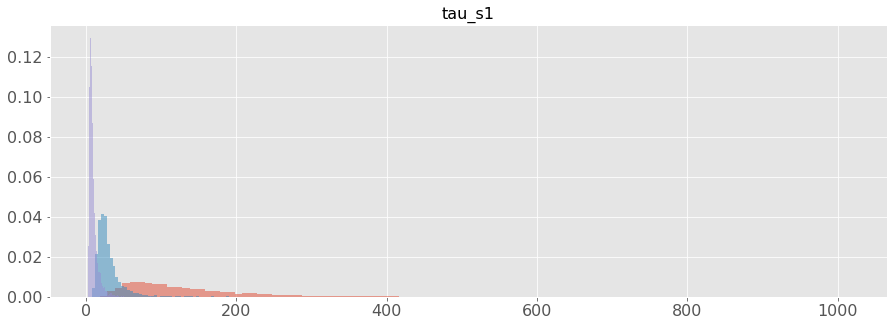

In [30]:
plt.figure(figsize=(15,5), facecolor='white')
plt.plot(trace.get_values('eps'), alpha=.6)
plt.title('tau_s1')
plt.figure()
plt.figure(figsize=(15,5), facecolor='white')
for i in range(trace.get_values('eps').shape[1]):
    plt.hist(trace.get_values('eps')[:, i], bins=100, density=True, alpha=.5)
plt.title('tau_s1');

(array([ 60.,  82.,  95., 142., 196., 277., 300., 229., 104.,  15.]),
 array([ 0.05623459,  1.23574768,  2.41526078,  3.59477387,  4.77428696,
         5.95380006,  7.13331315,  8.31282624,  9.49233934, 10.67185243,
        11.85136553]),
 <BarContainer object of 10 artists>)

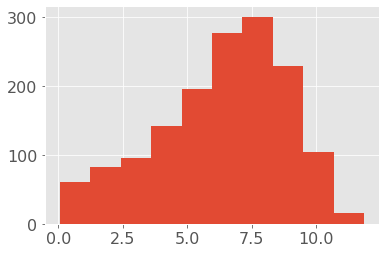

In [23]:
 plt.hist(trace.get_values('b')[:, 2])

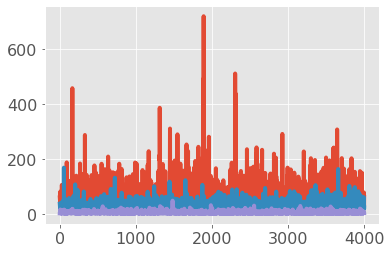

In [33]:
plt.plot(gb.traces['sigmas_squared'])

KeyError: 'tau_s1'

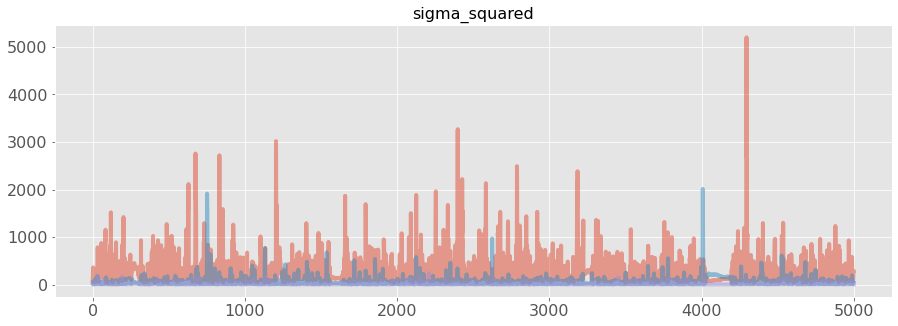

<Figure size 1080x360 with 0 Axes>

In [72]:
plt.figure(figsize=(15,5), facecolor='white')
plt.plot(trace.get_values('noise'), alpha=.5)
plt.title('sigma_squared')
plt.figure(figsize=(15,5), facecolor='white')
plt.plot(trace.get_values('tau_s1'), alpha=.5)
plt.title('tau_squared')

plt.figure(figsize=(15,5), facecolor='white')
plt.plot(np.sqrt(trace.get_values('tau_s1')+trace.get_values('noise')), alpha=.5)
plt.title('tau+sigma gp')


plt.figure(figsize=(15,5), facecolor='white')
plt.plot(np.sqrt(gb.traces['sigmas_squared']), alpha=.5)
plt.title('sigma gibbs')


In [25]:
with model:
    predictive_checks = pm.sample_posterior_predictive(trace, return_inferencedata=False, samples=100)

/var/folders/5t/ltqvfkd124z1n5v3ntgw77d40000gn/T/ipykernel_58662/3593972769.py:2: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  predictive_checks = pm.sample_posterior_predictive(trace, return_inferencedata=False, samples=100)


In [26]:
col_names = ['check' + str(num) for num in range(predictive_checks['y'].shape[0])]
df[col_names] = predictive_checks['y'].T;

/var/folders/5t/ltqvfkd124z1n5v3ntgw77d40000gn/T/ipykernel_58662/1829581080.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col_names] = predictive_checks['y'].T;
/var/folders/5t/ltqvfkd124z1n5v3ntgw77d40000gn/T/ipykernel_58662/1829581080.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col_names] = predictive_checks['y'].T;
/var/folders/5t/ltqvfkd124z1n5v3ntgw77d40000gn/T/ipykernel_58662/1829581080.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many t

In [27]:
def plot_checks(df, all_axes, col_names):
    ax_number = list(grouped_dataframe.groups.keys()).index(df.name)
    ax = all_axes.flatten()[ax_number]
    data = df[col_names].to_numpy()
    ax.plot(df['day_of_the_year'], df['avg_change_baseline_incidents'], color='black', zorder=3)
    ax.scatter(df['day_of_the_year'], df['avg_change_baseline_incidents'], color='red', s=100, zorder=3)
    ax.plot(df['day_of_the_year'], df[col_names], color='dodgerblue', alpha=.2)
    ax.set_title(df.name)
    ax.legend(['_', 'data', 'sample posterior predictive'], loc='upper right')
    ax.set_xlabel('day of 2020')
    ax.set_ylabel('% change incidents')
    plt.close()

fig, axes = plt.subplots(len(groups), 1, figsize=(20, len(groups) * 4), facecolor='white') 
grouped_dataframe = df.groupby('department_name')
grouped_dataframe.apply(lambda x: plot_checks(x, all_axes=axes, col_names=col_names))
fig.tight_layout()
fig.savefig('../figures/pred_checks.png', dpi=300, bbox_inches='tight')

/var/folders/5t/ltqvfkd124z1n5v3ntgw77d40000gn/T/ipykernel_58662/648952874.py:9: UserWarning: The handle <matplotlib.lines.Line2D object at 0x1732943d0> has a label of '_' which cannot be automatically added to the legend.
  ax.legend(['_', 'data', 'sample posterior predictive'], loc='upper right')
/var/folders/5t/ltqvfkd124z1n5v3ntgw77d40000gn/T/ipykernel_58662/648952874.py:9: UserWarning: The handle <matplotlib.lines.Line2D object at 0x1733565f0> has a label of '_' which cannot be automatically added to the legend.
  ax.legend(['_', 'data', 'sample posterior predictive'], loc='upper right')
/var/folders/5t/ltqvfkd124z1n5v3ntgw77d40000gn/T/ipykernel_58662/648952874.py:9: UserWarning: The handle <matplotlib.lines.Line2D object at 0x17344e7d0> has a label of '_' which cannot be automatically added to the legend.
  ax.legend(['_', 'data', 'sample posterior predictive'], loc='upper right')
/var/folders/5t/ltqvfkd124z1n5v3ntgw77d40000gn/T/ipykernel_58662/648952874.py:9: UserWarning: The ha